<a href="https://colab.research.google.com/github/dwjang0902/ExampleNew/blob/master/TimeSeries_RNN_52.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

참조 : https://www.math.purdue.edu/~nwinovic/slides/Getting_Started_with_TensorFlow_I.pdf
http://androidkt.com/time-series/
https://medium.com/the-artificial-impostor/notes-understanding-tensorflow-part-2-f7e5ece849f5

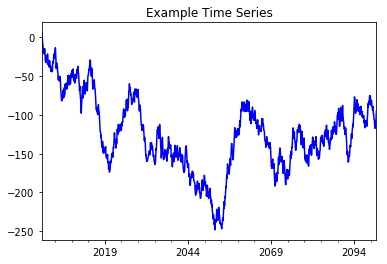

/usr/local/lib/python3.6/dist-packages/matplotlib/legend.py:497: UserWarning: Unrecognized location " upper right". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


<function matplotlib.pyplot.show>

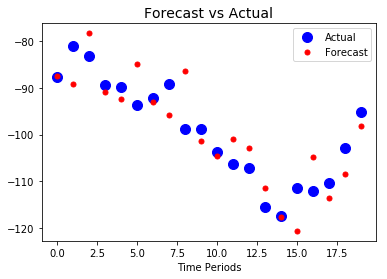

In [0]:
# Example #1 MUlti-RNN
# https://mapr.com/blog/deep-learning-tensorflow/
# 2019.04.30/수
import sys
sys.version

import tensorflow as tf
import pandas as pd
import os
import matplotlib.pyplot as plt
import random
import numpy as np

#--------------------------------------------------------------------------------------
random.seed(777)

rng = pd.date_range(start = '2000', periods = 1209, freq = "M" )
ts = pd.Series(np.random.uniform(-10, 10, size = len(rng)), rng).cumsum()
ts.plot(c = 'b', title = 'Example Time Series')
plt.show()
ts.head(10)

TS = np.array(ts)
num_periods = 20
f_horizon = 1


x_data = TS[:(len(TS)-(len(TS) % num_periods))]
x_batches = x_data.reshape(-1, num_periods, 1)

y_data = TS[1:(len(TS)-(len(TS) % num_periods))+f_horizon]
y_batches = y_data.reshape(-1, num_periods, 1)

#print(len(x_batches))
#print(x_batches.shape)
#print(x_batches[0:1])

#print(len(y_batches))
#print(y_batches.shape)
#print(y_batches[0:1])

# x_test
def test_data(series, forecast, num_periods) :
    test_x_setup = TS[-(num_periods+forecast):]
    testX = test_x_setup[:num_periods].reshape(-1,num_periods,1)
    testY = TS[-(num_periods):].reshape(-1,num_periods,1)
    return testX, testY
x_test, y_test = test_data(TS, f_horizon, num_periods)

#-------------------------------------------------------------------------------
tf.reset_default_graph()

#num_periods = 20
inputs = 1
hidden = 100
output = 1

x = tf.placeholder(tf.float32, [None, num_periods, inputs])
y = tf.placeholder(tf.float32, [None, num_periods, output])

"""
# 여기와 같이 다중셀을 정의하면 에러가 난다
#cell = tf.contrib.rnn.BasicRNNCell(num_units = hidden) # 기본셀을 정의한다
cell  = tf.nn.rnn_cell.BasicRNNCell(num_units = hidden) # 기본셀을 정의한다
cells = tf.nn.rnn_cell.MultiRNNCell([cell]*2)
outputs, _states = tf.nn.dynamic_rnn(cells, x, dtype = tf.float32) # 출력
"""
# multi-cell 사용하는 방법  ???
# 참조 : https://github.com/tensorflow/tensorflow/issues/16186
def lstm_cell():
   lstm = tf.contrib.rnn.BasicLSTMCell(hidden, forget_bias=1.0)
   return lstm
cells = tf.contrib.rnn.MultiRNNCell([lstm_cell() for _ in range(3)])
outputs, _states = tf.nn.dynamic_rnn(cells, x, dtype = tf.float32) # 출력


learning_rate = 0.01

stacked_rnn_outputs = tf.reshape(outputs, [-1, hidden])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs , output)
outputs = tf.reshape(stacked_outputs, [-1, num_periods, output])

loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

epoches = 10000

#---------------------------------------------------------------------------------------
with tf.Session() as sess :
    sess.run(init)
    for ep in range(epoches) :
        sess.run(training_op, feed_dict = { x : x_batches, y: y_batches})
        
        if ep % 100 == 0 :
            mse = loss.eval(feed_dict = { x : x_batches, y: y_batches})
#            print(ep, "\MSE ", mse)

    y_pred = sess.run(outputs, feed_dict = {x:x_test})
#    print(" Prediction = \n ", y_pred)
        
#------------------------------------------------------------------------------------------
plt.title("Forecast vs Actual", fontsize = 14)
plt.plot( pd.Series(np.ravel(y_test)), "bo", markersize = 10, label ="Actual")

plt.plot(pd.Series(np.ravel(y_pred)), "r.", markersize = 10, label = "Forecast")
plt.legend(loc = " upper right")
plt.xlabel("Time Periods")
plt.show
        

INFO:tensorflow:Tensorflow version 1.13.1
(840, 20, 1)
(360, 20, 1)
num_batches 26


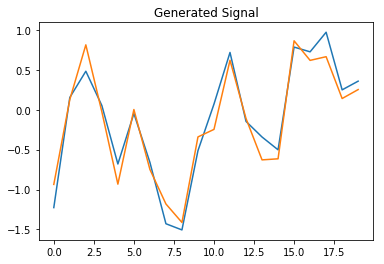

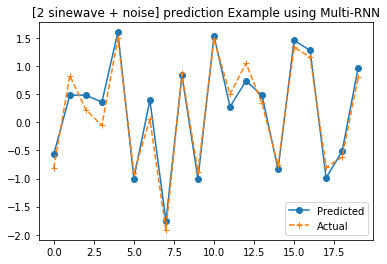

In [0]:
# Example #2
#  참조 : http://androidkt.com/time-series/

import sklearn 
from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib import pyplot as plt
 
import tensorflow as tf
from tensorflow.python.platform import tf_logging as logging
 
logging.set_verbosity(logging.INFO)
logging.log(logging.INFO, "Tensorflow version " + tf.__version__)
import keras 

tf.reset_default_graph()
    
# Simulate Time Series Data ; 2 sinewave + noise
def generate_time_series(datalen, signal2noise_ratio = 10.): # 데이타 생성
    signal2noise_ratio = np.power(10, -signal2noise_ratio / 10.)
    freq1 = 0.2
    freq2 = 0.15
    noise = [np.random.random() * signal2noise_ratio  for i in range(datalen)]
    x1 = np.sin(np.arange(0, datalen) * freq1)
    x2 = np.sin(np.arange(0, datalen) * freq2)
    x = (x1 + x2) + noise
    return x.astype(np.float32)

def train_dataset():
    dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
    dataset = dataset.repeat()
    dataset = dataset.shuffle(DATA_SEQ_LEN * 4 // SEQLEN)
    dataset = dataset.batch(BATCHSIZE)
    samples, labels = dataset.make_one_shot_iterator().get_next()
    return samples, labels
 
 
def eval_dataset():
    evaldataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
    evaldataset = evaldataset.repeat(1)
    evaldataset = evaldataset.batch(BATCHSIZE)
 
    samples, labels = evaldataset.make_one_shot_iterator().get_next()
    return samples, labels

 
DATA_SEQ_LEN = 24000
signal2noise_ratio = 20.
                
data = generate_time_series(DATA_SEQ_LEN,signal2noise_ratio)
#plt.plot(data[0:200])
#plt.title("Generated Signal : 2 sine wave + noise")
#plt.xlabel(" Num. of Sample")

SEQLEN = 20   # unrolled sequence length; time-steps; RNN의 셀의 수를 의미
BATCHSIZE = 32 # 배치 사이즈
 
X = data # 입력 데이타
Y = np.roll(data, -1) # shift left 1 # 타겟데이터

# 데이터 스플리팅
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,test_size=.3, random_state=0)

# 네트워크에 입력가능하도록 데이타의 쉐입변경
X_train = np.reshape(X_train, [-1, SEQLEN,1]) #3차원
Y_train = np.reshape(Y_train, [-1, SEQLEN,1])
X_test = np.reshape(X_test, [-1, SEQLEN,1])
Y_test = np.reshape(Y_test, [-1, SEQLEN,1])

print(X_train.shape)
print(X_test.shape )
plt.figure(1)
#plt.subplot(1,2,1)
plt.title("Generated Signal")
plt.plot(X_train[100])
plt.plot(Y_train[100])



# Model
# 파라미터 
hidden_size = 20 # 셀의 히든 스테이트 사니즈
input_size  = 1 # 셀 입력의 디벤젼
output_size = 1 # 셀의 출력 디멘젼

X = tf.placeholder(tf.float32, [None, SEQLEN, input_size]) # 3차원이 되어야 한다
Y = tf.placeholder(tf.float32, [None, SEQLEN,output_size]) # 

# 단일층
#sess = tf.InteractiveSession()
#cell = tf.contrib.rnn.BasicRNNCell(hidden_size)
#outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype = tf.float32) # outputs = [batch_size, seq_len(max_time), hidden_size]; _states = [batch_size, hidden_size]

#다중층
def lstm_cell():
   lstm = tf.contrib.rnn.BasicLSTMCell(hidden_size, forget_bias=1.0)
   return lstm
cells = tf.contrib.rnn.MultiRNNCell([lstm_cell() for _ in range(3)])
outputs, _states = tf.nn.dynamic_rnn(cells, X, dtype = tf.float32) # 출력

#sess.run(init)
#print( outputs.eval(feed_dict = { X :X_train[100:102]}) ) #[배치사이즈, 시퀀스사이즈, 히든사이즈]


stacked_rnn_outputs = tf.reshape(outputs, [-1, hidden_size])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs , output_size, kernel_initializer=None)
outputs = tf.reshape(stacked_outputs, [-1, SEQLEN, output_size])
predictions = outputs

# 이것이 동작하도록 고치자!
#w = tf.Variable(tf.zeros([output_size, SEQLEN],dtype = tf.float32))
#b = tf.Variable(tf.zeros([output_size],dtype = tf.float32))
#predictions = [tf.matmul(w,outputs[i]) + b for i in range(tf.shape(outputs)[0])]
#--------------------------------------------------------------------------------------
#softmax_w = tf.Variable(tf.random_normal(shape=[hidden_size, output_size]), dtype=tf.float32)
#softmax_b = tf.Variable(tf.random_normal(shape=[output_size]), dtype=tf.float32)

#output = tf.reshape(outputs, [-1, hidden_size]) 
# 최종 출력값을 설정합니다.
# logits : [batch_size * seq_length, output_size]
#logits = tf.matmul(output, softmax_w) + softmax_b
#probs = tf.nn.softmax(logits)
# 이 경우에는 target 도  [batch_size * seq_length, output_size]로 바꾸어 주어야 한다
#--------------------------------------------------------------------------------------

loss = tf.losses.mean_squared_error(predictions = predictions, labels = Y,  weights=1.0)
loss_total = tf.reduce_mean(loss)  

optimizer = tf.train.AdamOptimizer(0.001)
train_opt = optimizer.minimize(loss)

init = tf.global_variables_initializer()

epochs = 10
num_batches = np.int((X_train.shape[0] / BATCHSIZE))
print("num_batches", num_batches)
with tf.Session() as sess :
    sess.run(init)
    for i in range(epochs) :
        for j in range(num_batches) :
            x_batch, y_batch = X_train[j:j+BATCHSIZE,:,:], Y_train[j:j+BATCHSIZE,:,:]
#            print(np.shape(x_batch))
            sess.run(train_opt, feed_dict = {X : x_batch, Y : y_batch})
    
#    print(loss_total.eval(feed_dict = {X : X_test[100:101], Y : Y_test[100:101]}))     
#    print(predictions.eval(feed_dict = {X : X_test[100:101]}), "\n", Y_test[100:101])
   
# one-sequence plot
    x_out = np.squeeze(predictions.eval(feed_dict = {X : X_test[100:101]}))
    y_out =  np.squeeze(Y_test[100:101])
    plt.figure(2)
#    plt.subplot(1,2,2)
    plt.plot(x_out,'-o', label='Predicted')
    plt.plot(y_out,'--+', label='Actual')
    plt.title("[2 sinewave + noise] prediction Example using Multi-RNN")
    plt.legend(loc='lower right')
    plt.show()
    

INFO:tensorflow:Tensorflow version 1.13.1
(840, 20, 1)
(360, 20, 1)
num_batches 26


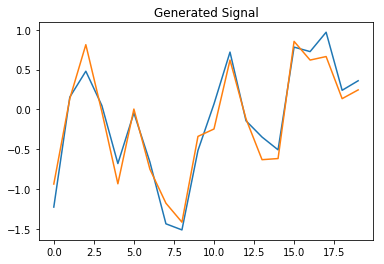

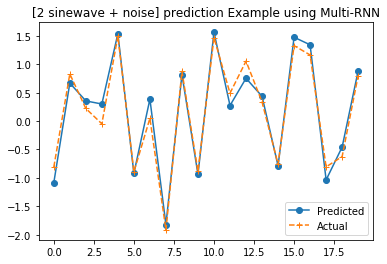

In [0]:
# Example #3
#  참조 : http://androidkt.com/time-series/

import sklearn 
from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib import pyplot as plt
 
import tensorflow as tf
from tensorflow.python.platform import tf_logging as logging
 
logging.set_verbosity(logging.INFO)
logging.log(logging.INFO, "Tensorflow version " + tf.__version__)
import keras 

tf.reset_default_graph()
    
# Simulate Time Series Data ; 2 sinewave + noise
def generate_time_series(datalen, signal2noise_ratio = 10.): # 데이타 생성
    signal2noise_ratio = np.power(10, -signal2noise_ratio / 10.)
    freq1 = 0.2
    freq2 = 0.15
    noise = [np.random.random() * signal2noise_ratio  for i in range(datalen)]
    x1 = np.sin(np.arange(0, datalen) * freq1)
    x2 = np.sin(np.arange(0, datalen) * freq2)
    x = (x1 + x2) + noise
    return x.astype(np.float32)

def train_dataset():
    dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
    dataset = dataset.repeat()
    dataset = dataset.shuffle(DATA_SEQ_LEN * 4 // SEQLEN)
    dataset = dataset.batch(BATCHSIZE)
    samples, labels = dataset.make_one_shot_iterator().get_next()
    return samples, labels
 
 
def eval_dataset():
    evaldataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
    evaldataset = evaldataset.repeat(1)
    evaldataset = evaldataset.batch(BATCHSIZE)
 
    samples, labels = evaldataset.make_one_shot_iterator().get_next()
    return samples, labels

 
DATA_SEQ_LEN = 24000
signal2noise_ratio = 20.
                
data = generate_time_series(DATA_SEQ_LEN,signal2noise_ratio)
#plt.plot(data[0:200])
#plt.title("Generated Signal : 2 sine wave + noise")
#plt.xlabel(" Num. of Sample")

SEQLEN = 20   # unrolled sequence length; time-steps; RNN의 셀의 수를 의미
BATCHSIZE = 32 # 배치 사이즈
 
X = data # 입력 데이타
Y = np.roll(data, -1) # shift left 1 # 타겟데이터

# 데이터 스플리팅
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,test_size=.3, random_state=0)

# 네트워크에 입력가능하도록 데이타의 쉐입변경
X_train = np.reshape(X_train, [-1, SEQLEN,1]) #3차원
Y_train = np.reshape(Y_train, [-1, SEQLEN,1])
X_test = np.reshape(X_test, [-1, SEQLEN,1])
Y_test = np.reshape(Y_test, [-1, SEQLEN,1])

print(X_train.shape)
print(X_test.shape )
plt.figure(1)
#plt.subplot(1,2,1)
plt.title("Generated Signal")
plt.plot(X_train[100])
plt.plot(Y_train[100])



# Model
# 파라미터 
hidden_size = 20 # 셀의 히든 스테이트 사니즈
input_size  = 1 # 셀 입력의 디벤젼
output_size = 1 # 셀의 출력 디멘젼

X = tf.placeholder(tf.float32, [None, SEQLEN, input_size]) # 3차원이 되어야 한다
Y = tf.placeholder(tf.float32, [None, SEQLEN,output_size]) # 

# 단일층
#sess = tf.InteractiveSession()
#cell = tf.contrib.rnn.BasicRNNCell(hidden_size)
#outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype = tf.float32) # outputs = [batch_size, seq_len(max_time), hidden_size]; _states = [batch_size, hidden_size]

#다중층
def lstm_cell():
   lstm = tf.contrib.rnn.BasicLSTMCell(hidden_size, forget_bias=1.0)
   return lstm
cells = tf.contrib.rnn.MultiRNNCell([lstm_cell() for _ in range(5)])
outputs, _states = tf.nn.dynamic_rnn(cells, X, dtype = tf.float32) # 출력

softmax_w = tf.Variable(tf.random_normal(shape=[hidden_size, output_size]), dtype=tf.float32)
softmax_b = tf.Variable(tf.random_normal(shape=[output_size]), dtype=tf.float32)
output = tf.reshape(outputs, [-1, hidden_size]) 

# 최종 출력값을 설정합니다; 일종의 dense_layer 추가 ...
logits = tf.matmul(output, softmax_w) + softmax_b # logits : [batch_size * seq_length, output_size]
predictions = logits
#predictions  = tf.nn.softmax(logits) # 이것은 잘 동작하지 않는다.

# 이 경우에는 target도 아래와 같이 [batch_size * seq_length, output_size]로 바꾸어 주어야 한다
loss = tf.losses.mean_squared_error(predictions = predictions, labels = tf.reshape(Y, [-1,output_size]),  weights=1.0)
loss_total = tf.reduce_mean(loss)  

optimizer = tf.train.AdamOptimizer(0.01)
train_opt = optimizer.minimize(loss)

init = tf.global_variables_initializer()

epochs = 10
num_batches = np.int((X_train.shape[0] / BATCHSIZE))
print("num_batches", num_batches)
with tf.Session() as sess :
    sess.run(init)
    for i in range(epochs) :
        for j in range(num_batches) :
            x_batch, y_batch = X_train[j:j+BATCHSIZE,:,:], Y_train[j:j+BATCHSIZE,:,:]
#            print(np.shape(x_batch))
            sess.run(train_opt, feed_dict = {X : x_batch, Y : y_batch})
    
#    print(loss_total.eval(feed_dict = {X : X_test[100:101], Y : Y_test[100:101]}))     
#    print(predictions.eval(feed_dict = {X : X_test[100:101]}), "\n", Y_test[100:101])
   
# one-sequence plot
    x_out = np.squeeze(predictions.eval(feed_dict = {X : X_test[100:101]}))
    y_out =  np.squeeze(Y_test[100:101])
    plt.figure(2)
#    plt.subplot(1,2,2)
    plt.plot(x_out,'-o', label='Predicted')
    plt.plot(y_out,'--+', label='Actual')
    plt.title("[2 sinewave + noise] prediction Example using Multi-RNN")
    plt.legend(loc='lower right')
    plt.show()

In [0]:
# Example #4